# Volumetric inverse rendering

## Overview

In this tutorial, we are going to see how to use volumetric inverse rendering to optimize a volume grid to match the appearance of a mesh.

<div class="admonition important alert alert-block alert-success">

🚀 **What will you learn?**
    
    
<ul>
  <li>Construct a scene with volumes</li>
  <li>Add regularization term to your objective function</li>
  <li>Optimize a volume grid to match a set of reference images</li>
</ul>
    
</div>


## Step 1 - Setup

As always, we start with the usual imports and set a variant that supports automatic differentation.

In [1]:
import matplotlib.pyplot as plt 

import drjit as dr
import mitsuba as mi

mi.set_variant('llvm_ad_rgb')

## Step 2 - Create sensors

There are often many solutions to a given set of constraints when optimizing a volume grid, which often don't generalize. For instance, if we optimize a volume given a single reference image, the optimized volume is likely to only contain dense voxels in the part closer to the camera, which would look wrong from a different angle. 

Therefore, multi-view optimization must be used to optimize a volume that looks reasonable from other points of view. In this tutorial, we first create 5 sensors placed around the origin on a half circle.

In [2]:
from mitsuba.scalar_rgb import ScalarTransform4f as T

sensor_count = 5
sensors = []

for i in range(sensor_count):
    angle = 180.0 / sensor_count * i - 90.0 
    sensor_rotation = T.rotate([0, 1, 0], angle) 
    sensor_to_world = T.look_at(
        target=[0, 0, 0],
        origin=[0, 0, 4],
        up=[0, 1, 0]
    )
    sensors.append(mi.load_dict({
        'type': 'perspective',
        'near_clip': 1,
        'far_clip': 1000,
        'fov': 45,
        'to_world': sensor_rotation * sensor_to_world,
        'film': {
            'type': 'hdrfilm',
            'width': 64,
            'height': 64,
            'pixel_format': 'rgb',
        }
    }))

## Step 3 - Reference scene

Let's now create a simple scene with constant illumation and a Stanford Bunny placed at the origin. We render this with all the sensors we created in the last step and store those in an array for later use.

In [3]:
scene_dict = {
    'type': 'scene',
    'integrator': {
        'type': 'prbvolpath',
    },
    'object': {
        'type': 'ply',
        'filename': '../../scenes/meshes/bunny.ply',
        'to_world': T.scale(10.0),
        'bsdf': {
            'type': 'diffuse',
            'reflectance': { 'type': 'rgb', 'value': [0.4, 0.4, 0.4] },
        },
    },
    'emitter': { 'type': 'constant' }
}

scene_ref = mi.load_dict(scene_dict)

2022-04-05 14:47:14 WARN main [Scene] No sensors found! Instantiating a perspective camera..

2022-04-05 14:47:14 INFO main [Scene] Embree ready. (took 22ms)

In [4]:
ref_images = [mi.render(scene_ref, sensor=sensors[i], spp=128) for i in range(sensor_count)]

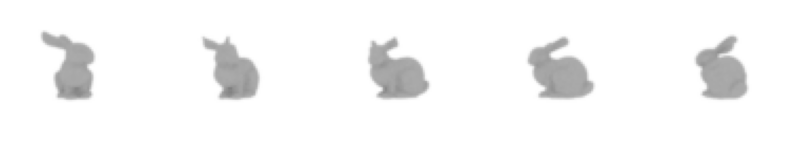

In [5]:
fig, axs = plt.subplots(1, sensor_count, figsize=(14, 4))
for i in range(sensor_count):
    axs[i].imshow(mi.util.convert_to_bitmap(ref_images[i]))
    axs[i].axis('off')

## Step 4 - Optimization scene

We modify the scene dictionary to replace the mesh object with a simple cube that contains a heterogeneous volume.

In [6]:
volume_shape = (64, 64, 64, 1)

# Update the scene dictionary
scene_dict['object'] = { 
    'type': 'cube',
    'interior': {
        'type': 'heterogeneous',
        'sigma_t': {
            'type': 'gridvolume',
            'grid': mi.VolumeGrid(dr.full(mi.TensorXf, 0.002, volume_shape)),
            'to_world': T.translate(-1) * T.scale(2.0)
        },
        'albedo': {
            'type': 'constvolume',
            'value': { 'type': 'rgb', 'value': [0.4, 0.4, 0.4] },
            'to_world': T.translate(-1) * T.scale(2.0)
        },
        'phase': {
            'type': 'isotropic'
        },
        'scale': 25.0,
        'sample_emitters': False,
    },
    'bsdf': {
        'type': 'dielectric',
        'int_ior': 'air',
    },
}

scene = mi.load_dict(scene_dict)

2022-04-05 14:47:15 WARN main [Scene] No sensors found! Instantiating a perspective camera..

2022-04-05 14:47:15 INFO main [Scene] Embree ready. (took 0ms)

We visualize the modified scene from all view angles. Those are going to be our initial image in the optimization process.

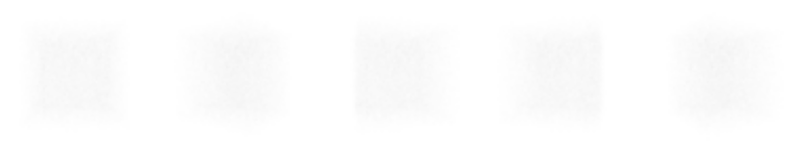

In [7]:
init_images = [mi.render(scene, sensor=sensors[i], spp=128) for i in range(sensor_count)]

fig, axs = plt.subplots(1, sensor_count, figsize=(14, 4))
for i in range(sensor_count):
    axs[i].imshow(mi.util.convert_to_bitmap(init_images[i]))
    axs[i].axis('off')

## Step 5 - Optimization

We instantiate an `Adam` optimizer and load the `sigma_t` grid data as parameter to be optimized.

In [8]:
params = mi.traverse(scene)

key = 'object.interior_medium.sigma_t.data'

opt = mi.ad.Adam(lr=0.02, params=params)
opt.load(key)
opt.update()

We perform the optimization loop, similarily to the other tutorials.

One important detail here is the use of a regularization term to minimize the total density in the volume. This will help the volume to focus on the parts that are important, and make the non-relevant parts of the volume to disappear.

In [9]:
losses = []

for it in range(25):
    total_loss = 0.0
    for sensor_idx in range(sensor_count):
        # Perform the differentiable light transport simulation
        img = mi.render(scene, params, sensor=sensors[sensor_idx], spp=16, seed=it)
        
        # L2 loss function
        loss = dr.hsum_async(dr.sqr(img - ref_images[sensor_idx])) / len(img)
        
        # Regularization term: minimize total density in the volume
        reg = dr.hmean_async(opt[key])
        
        # Backpropagate gradients for both the loss and regularization terms
        dr.backward(loss + reg)

        # Take a gradient step
        opt.step()
        
        # Clamp the optimized values to a valid range
        opt[key] = dr.clamp(opt[key], 1e-6, 1.0)
        
        # Propagate changes to the scene
        opt.update()
        
        total_loss += loss[0]

    losses.append(total_loss)
    print(f"Iteration {it:02d}: error={total_loss:6f}")

Iteration 00: error=0.147493
Iteration 01: error=0.090921
Iteration 02: error=0.088873
Iteration 03: error=0.066523
Iteration 04: error=0.047476
Iteration 05: error=0.034603
Iteration 06: error=0.030887
Iteration 07: error=0.027134
Iteration 08: error=0.022971
Iteration 09: error=0.019665
Iteration 10: error=0.017843
Iteration 11: error=0.016231
Iteration 12: error=0.016086
Iteration 13: error=0.015468
Iteration 14: error=0.015622
Iteration 15: error=0.014847
Iteration 16: error=0.014945
Iteration 17: error=0.014841
Iteration 18: error=0.014459
Iteration 19: error=0.014739
Iteration 20: error=0.014674
Iteration 21: error=0.013909
Iteration 22: error=0.013886
Iteration 23: error=0.013980
Iteration 24: error=0.014671


## Step 6 - Results

Finally we can take a look at the resulting volume from the different points of view.

In [10]:
final_images = [mi.render(scene, sensor=sensors[i], spp=128) for i in range(sensor_count)]

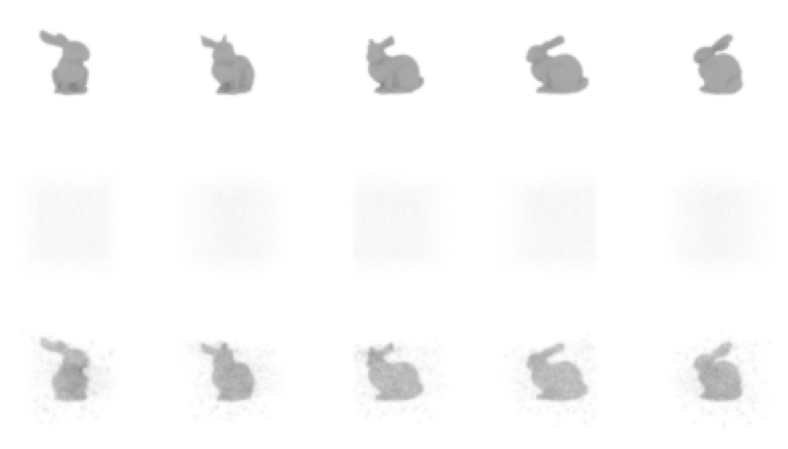

In [11]:
fig, axs = plt.subplots(3, sensor_count, figsize=(14, 8))
for i in range(sensor_count):
    axs[0][i].imshow(mi.util.convert_to_bitmap(ref_images[i]))
    axs[0][i].axis('off')
    axs[1][i].imshow(mi.util.convert_to_bitmap(init_images[i]))
    axs[1][i].axis('off')
    axs[2][i].imshow(mi.util.convert_to_bitmap(final_images[i]))
    axs[2][i].axis('off')

<div class="admonition note alert alert-block alert-info">

📑 **See also**
    
<ul>
  <li><a href="url"><tt>mitsuba.load_dict</tt></a></li>
</ul>
    
</div>